In [1]:
#With assistance from https://learnopencv.com/mask-r-cnn-instance-segmentation-with-pytorch/

from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2
import random
import time
import os



 # COCO Dataset instance categories
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [7]:
# get the pretrained model from torchvision.models
# model.eval() to use the model for inference
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [3]:
#Array of colors to choose from for color masking
colors = [  [0, 255, 0],
            [0, 0, 255],
            [255, 0, 0],
            [0, 255, 255],
            [255, 255, 0],
            [255, 0, 255],
            [80, 70, 180],
            [250, 80, 190],
            [245, 145, 50],
            [70, 150, 250],
            [50, 190, 190]]

In [4]:
#Grabs a random color to be used for masks
def random_color_masks(image):
    colors = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    r[image == 1], g[image == 1], b[image == 1] = colors[random.randrange(0,10)]
    colored_mask = np.stack([r, g, b], axis=2)
    return colored_mask

#Grab the image, transform the image, pass the image into the model, grab class / bounding box / and masks
def get_prediction(img_path, threshold):
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy().astype(int))]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class

In [5]:
# Helper function to achieve segmentation of the image(s)
def segmentation(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
    masks, boxes, pred_cls = get_prediction(img_path, threshold)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
        rgb_mask = random_color_masks(masks[i])
        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        pt1 = tuple([int(j) for j in boxes[i][0]])
        pt2 = tuple([int(j) for j in boxes[i][1]])
        cv2.rectangle(img, pt1, pt2, color=(0,255,0), thickness=rect_th)
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

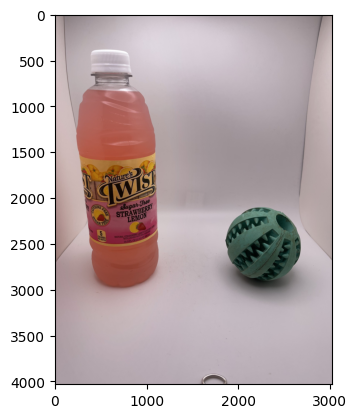

In [6]:
#Grab a specific image to be used for masking

image = Image.open('./project_data/both/IMG_6234.jpg')
plt.imshow(image)
plt.show()

In [7]:
# Running inference on the image
transform = T.Compose([T.ToTensor()])
img_tensor = transform(image)
pred = model([img_tensor])

In [8]:
pred

[{'boxes': tensor([[ 233.7544,  353.9264, 1137.7894, 3167.4995],
          [1848.0502, 2115.8240, 2670.1594, 2916.5427],
          [   0.0000,  874.1844, 3024.0000, 3927.8948],
          [ 311.9448, 1632.6724,  504.4377, 1822.5208],
          [ 330.7185, 1625.3524,  737.1423, 1826.9159],
          [ 298.4684, 1509.6251, 1139.7728, 3017.0828],
          [2626.3496,    0.0000, 3024.0000, 2900.3855]],
         grad_fn=<StackBackward0>),
  'labels': tensor([44, 37, 67, 52, 52, 44, 42]),
  'scores': tensor([0.9977, 0.7247, 0.6241, 0.3464, 0.2639, 0.2491, 0.0699],
         grad_fn=<IndexBackward0>),
  'masks': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            ...,
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.00

In [10]:
#Keeping only the pixels with values greater than 0.5 as 1
#The rest get set to 0
masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
masks.shape

(7, 4032, 3024)

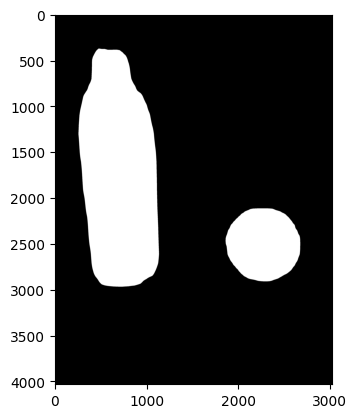

In [11]:
# Show the mask for the designated classes, in this case Bottle and Ball
plt.imshow(masks[0] + masks[1], cmap= 'gray')
plt.show()

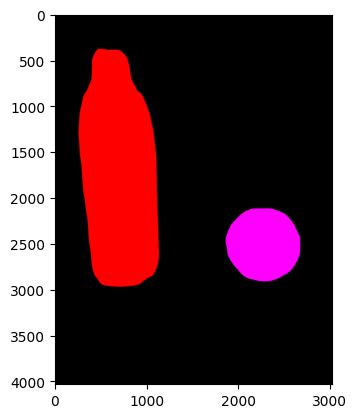

In [12]:
# Color the masks with the color randomizer
mask1 = random_color_masks(masks[0]) + random_color_masks(masks[1])
plt.imshow(mask1)
plt.show()

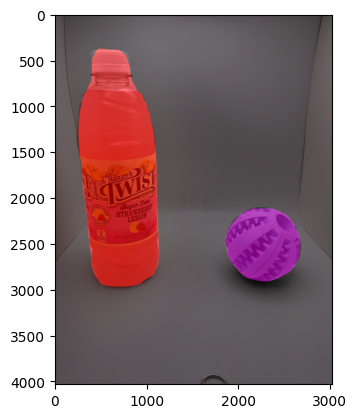

In [13]:
# Overlay the masks on the original image
blend_image = cv2.addWeighted(np.asarray(image), 0.5, mask1, 0.5, 0)

plt.imshow(blend_image)
plt.show()

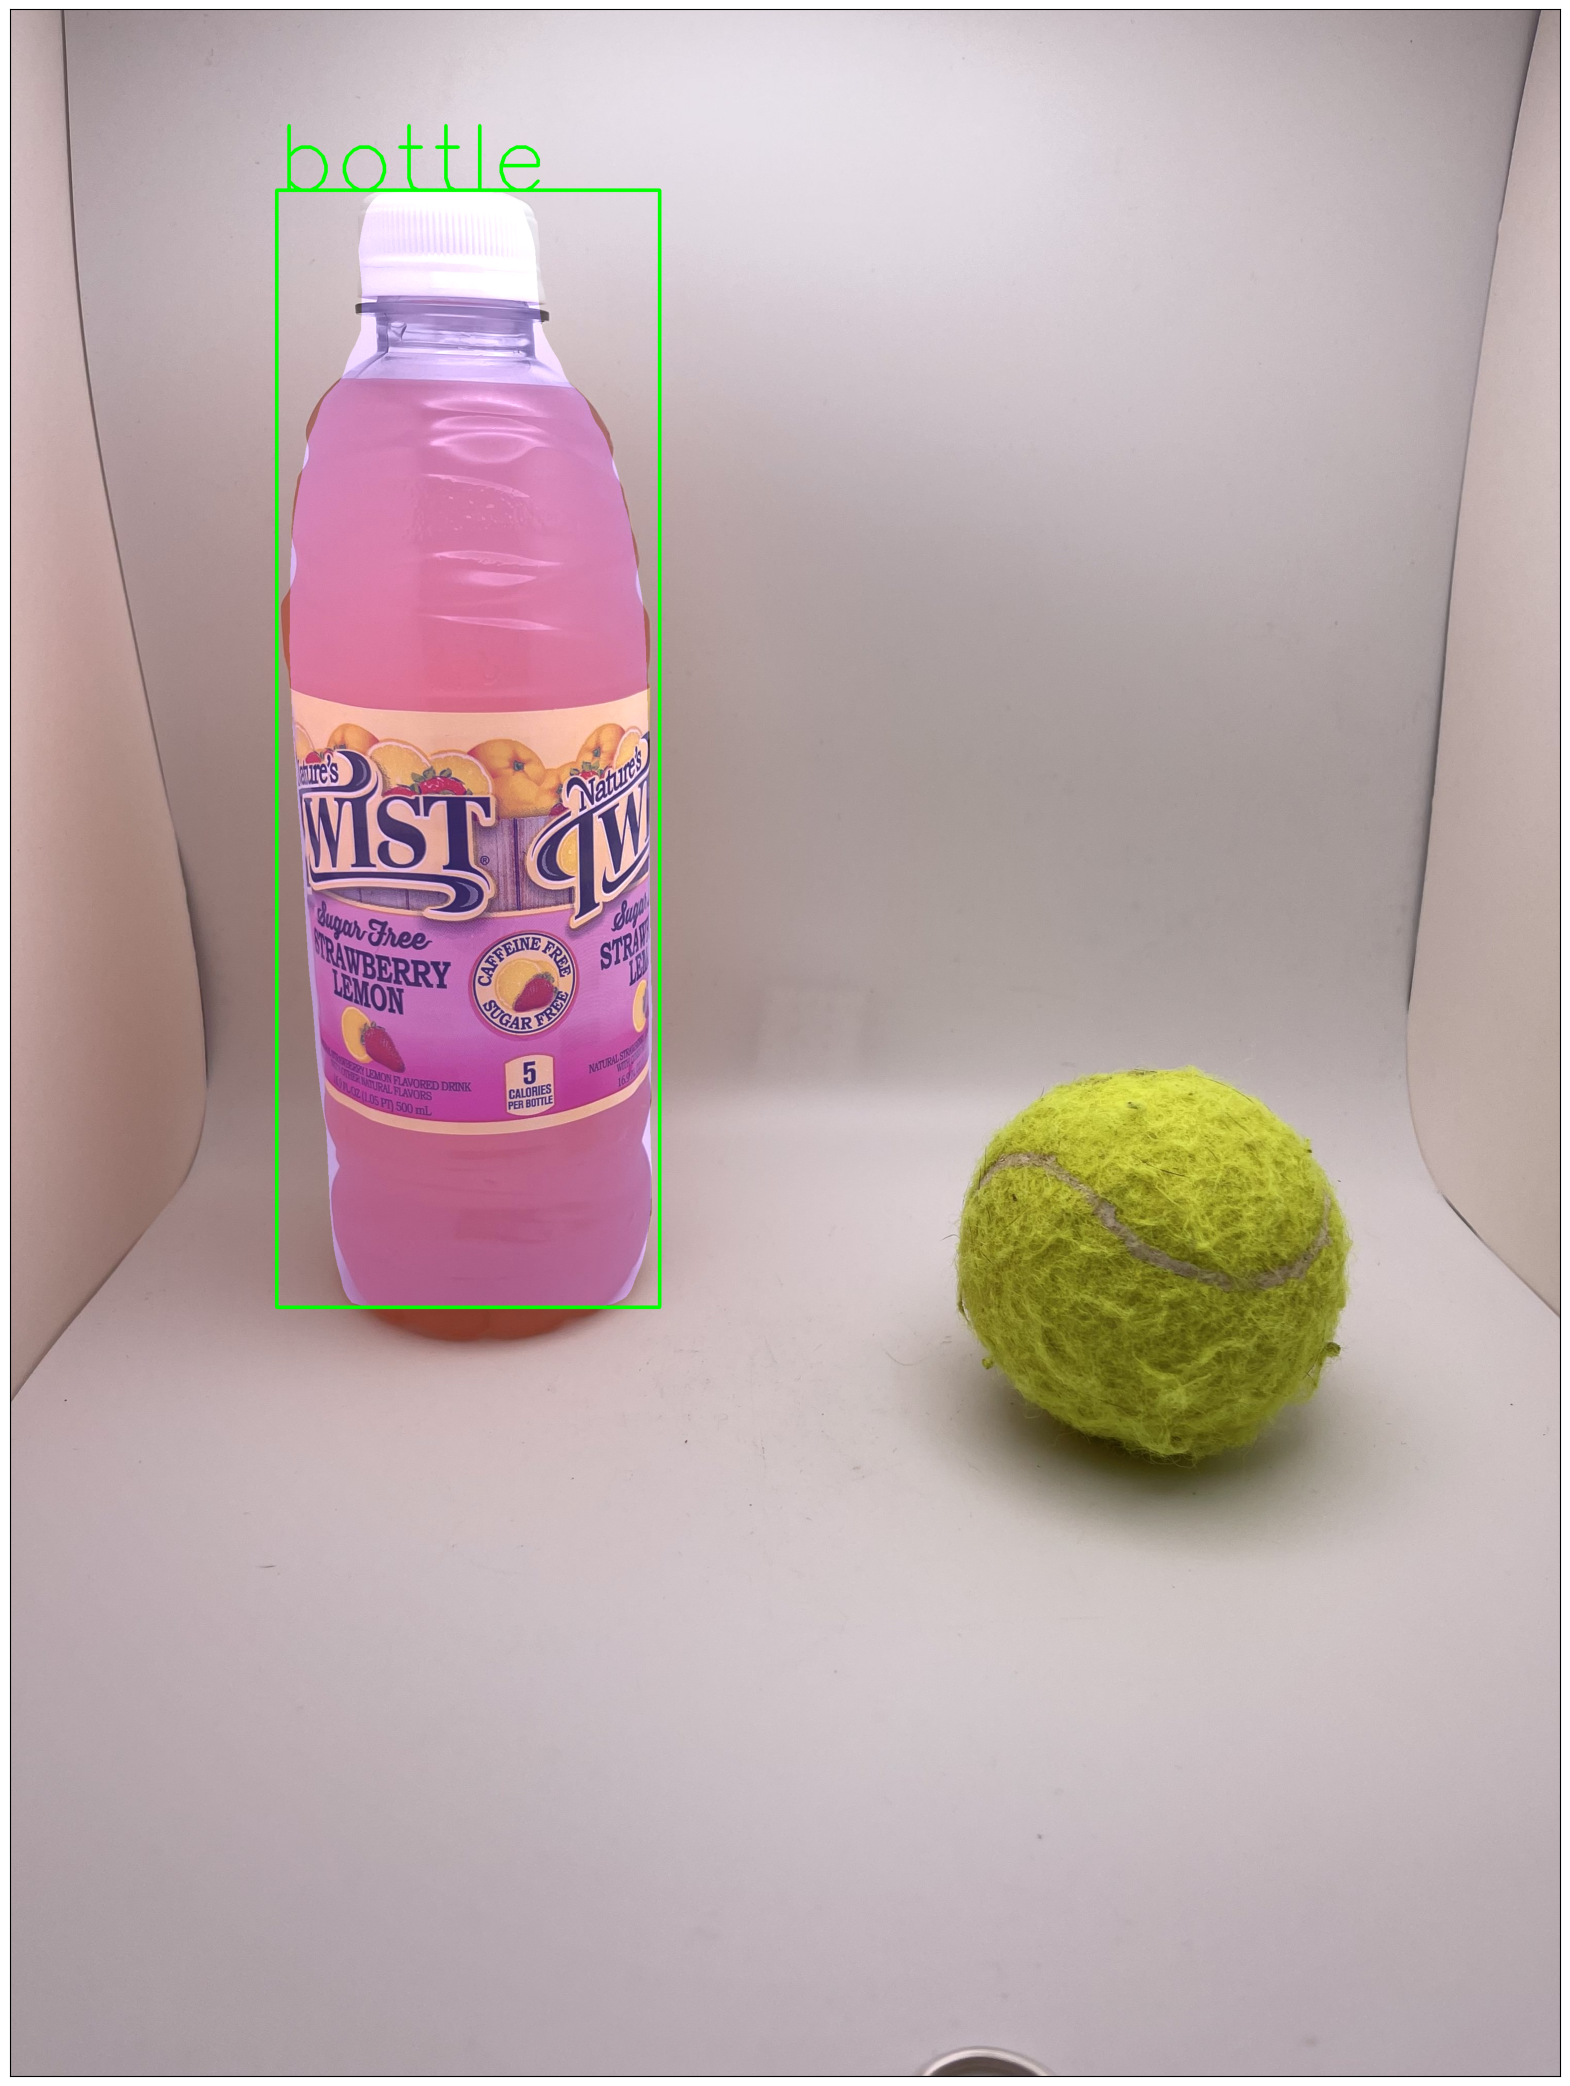

In [16]:
#Display a bounding box with classifier + segmentation mask overlayed on original image.
#Parameters can be adjusted to change the visualization of the bounding box and classification text
segmentation('./project_data/both/IMG_6237.jpg', 0.7, rect_th=6, text_size=6, text_th=6)